# Feature Engineering

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 10
PARAMS = dict(
    n_estimators = 1600,
    random_state = RANDOM_SEED, 
    n_jobs = -1
)

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import re
import math
import os
import pyarrow
import gc

# scikit-learn optimization
from sklearnex import patch_sklearn
patch_sklearn()

# Model evaluation
import optuna
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import validation_curve
import seaborn as sns

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image


# Hide warnings
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Helper Functions

In [3]:
# Helper functions from https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense/
from math import factorial
from random import choices, setstate
from collections import Counter
from itertools import product

def embed_4d(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return np.array([w, x, y, z])

def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return bias(w, x, y, z)

def get_histograms(input_df):
    return pd.DataFrame({
        col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
    })

def gcd_of_all(df_i):
    gcd = df_i[features[0]]
    for col in features[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

def get_target_bins():
    temp = train[['target','target']].copy()
    temp.columns = ['row_id','target']
    temp['row_id'] = gcd_of_all(get_histograms(train[features]))
    return temp['row_id'].astype(str) + temp['target'].astype(str)


def remove_duplicates(input_df, features):
    # Create a new dataframe without duplicates, but with an additional sample_weight column
    vc = input_df[features + ['target']].value_counts()
    dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns = input_df[features + ['target']].columns)
    dedup_train['sample_weight'] = vc.values
    return dedup_train

def load_data():
    train = pd.read_feather('../data/train.feather')
    features = [x for x in train.columns if x not in ['row_id', 'target']]

    # Label encoding
    encoder = LabelEncoder()
    train['target'] = encoder.fit_transform(train['target'])
    train = remove_duplicates(train, features)
    
    return train, encoder, features

# Scoring Function

In [4]:
# Scoring/Training Baseline Function
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    new_features = [x for x in train.columns if x not in ['row_id','target', 'sample_weight']]
    oof_preds = np.zeros((train.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, get_target_bins())):
        
        # Training and Validation Sets
        X_train, y_train = train[new_features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[new_features].iloc[valid_idx], train['target'].iloc[valid_idx]
        
        # Preprocessing
        start = time.time()
        if preprocessing:
            X_train = preprocessing.fit_transform(X_train)
            X_valid = preprocessing.transform(X_valid)
        
        # Create model
        model = clone(sklearn_model)
        model.fit(
            X_train, y_train, 
            sample_weight = train['sample_weight'].loc[train_idx]
        )

        
        # validation
        valid_preds = model.predict(X_valid)
        scores[fold] = accuracy_score(y_valid, valid_preds)
        oof_preds[valid_idx] = valid_preds
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        
        
    print("\nAccuracy (1M Reads):", round(accuracy_score(oof_preds[train_gcds == 1], train['target'].loc[train_gcds == 1]), 5))
    print("Accuracy (100k Reads):", round(accuracy_score(oof_preds[train_gcds == 10], train['target'].loc[train_gcds == 10]), 5))
    print("Accuracy (1k Reads):", round(accuracy_score(oof_preds[train_gcds == 1000], train['target'].loc[train_gcds == 1000]), 5))
    print("Accuracy (100 Reads):", round(accuracy_score(oof_preds[train_gcds == 10000], train['target'].loc[train_gcds == 10000]), 5))
    print("Average Accuracy:", round(scores.mean(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return oof_preds

# Confusion Matrix Plotting

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_values, pred_values, gcds, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,9))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
    plt.show()

# Load Data

In [6]:
%%time
from sklearn.preprocessing import LabelEncoder

train, encoder, features = load_data()
train_gcds = gcd_of_all(get_histograms(train[features]))

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 16.9 s
Wall time: 15.5 s


# Model

In [7]:
from sklearn.base import BaseEstimator, clone

class GCDEstimator(BaseEstimator):
    
    def __init__(self):
        self.model1 = ExtraTreesClassifier(**PARAMS)
        self.model2 = ExtraTreesClassifier(**PARAMS)
        self.model3 = ExtraTreesClassifier(**PARAMS)
        self.model4 = ExtraTreesClassifier(**PARAMS) 
    
    def gcd_of_all(self, df_i):
        gcd = df_i[features[0]]
        for col in features[1:]:
            gcd = np.gcd(gcd, df_i[col])
        self.gcd1 = (gcd == 1)
        self.gcd2 = (gcd == 10)
        self.gcd3 = (gcd == 1000)
        self.gcd4 = (gcd == 10000)
        
    def get_histograms(self, input_df):
        return pd.DataFrame({
            col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
        })
        
    def fit(self, X, y, sample_weight):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        self.num_labels = len(np.unique(y))
        self.model1.fit(X[self.gcd1], y[self.gcd1], sample_weight[self.gcd1])
        self.model2.fit(X[self.gcd2], y[self.gcd2], sample_weight[self.gcd2])
        self.model3.fit(X[self.gcd3], y[self.gcd3], sample_weight[self.gcd3])
        self.model4.fit(X[self.gcd4], y[self.gcd4], sample_weight[self.gcd4])
        
    def predict_proba(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),self.num_labels))
        temp[self.gcd1] = self.model1.predict_proba(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict_proba(X[self.gcd2])
        temp[self.gcd3] = self.model3.predict_proba(X[self.gcd3])
        temp[self.gcd4] = self.model4.predict_proba(X[self.gcd4])
        return temp
        
    def predict(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),))
        temp[self.gcd1] = self.model1.predict(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict(X[self.gcd2])
        temp[self.gcd3] = self.model3.predict(X[self.gcd3])
        temp[self.gcd4] = self.model4.predict(X[self.gcd4])
        return temp.astype(int)

# Baseline


Fold 0: 0.9796 accuracy in 61.42s.
Fold 1: 0.97806 accuracy in 62.91s.
Fold 2: 0.97702 accuracy in 61.21s.
Fold 3: 0.9796 accuracy in 61.34s.
Fold 4: 0.97822 accuracy in 61.39s.
Fold 5: 0.97806 accuracy in 61.79s.
Fold 6: 0.97758 accuracy in 62.39s.
Fold 7: 0.97766 accuracy in 62.43s.
Fold 8: 0.97911 accuracy in 62.9s.
Fold 9: 0.9775 accuracy in 61.79s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.92681
Accuracy (100 Reads): 0.89474
Average Accuracy: 0.97824
Training Time: 619.58s


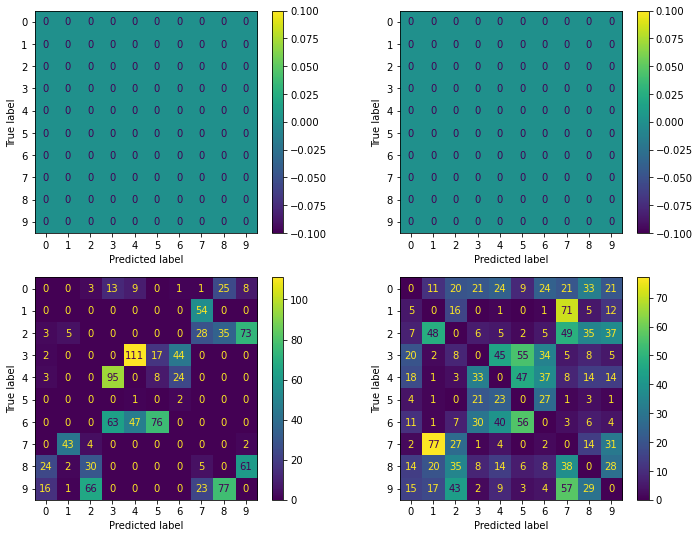

In [8]:
oof_preds = score_model(GCDEstimator())
plot_confusion_matrix(train['target'],oof_preds, train_gcds)

# Dual Features

We create an implicit graph structure by mapping each histogram into 4D space and connecting histograms which differ by one edit. Our new features will be the edge weights given by subtracting connected histograms based on their lexographical ordering.

In [9]:
from itertools import combinations

def neighbors(x,y):
    return np.sum(np.abs(x-y)) == 2

def flow_features(input_df):
    embeddings = {x:embed_4d(x) for x in features}
    for col1 in features:
        for col2 in features:
            x = embeddings[col1]
            y = embeddings[col2]
            input_df[col1 + '_flow'] = 0
            if neighbors(x,y):
                input_df[col1 + '_flow'] += input_df[col1] - input_df[col2]
    new_cols = [x for x in input_df.columns if x not in features]
    print('Number of new columns:', len(new_cols))
    return input_df 

Number of new columns: 288

Fold 0: 0.98008 accuracy in 83.61s.
Fold 1: 0.97677 accuracy in 84.15s.
Fold 2: 0.97782 accuracy in 84.43s.
Fold 3: 0.97976 accuracy in 84.36s.
Fold 4: 0.97871 accuracy in 84.36s.
Fold 5: 0.97847 accuracy in 84.22s.
Fold 6: 0.97709 accuracy in 84.09s.
Fold 7: 0.97734 accuracy in 84.42s.
Fold 8: 0.97855 accuracy in 84.1s.
Fold 9: 0.9783 accuracy in 86.08s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.92542
Accuracy (100 Reads): 0.89652
Average Accuracy: 0.97829
Training Time: 843.84s


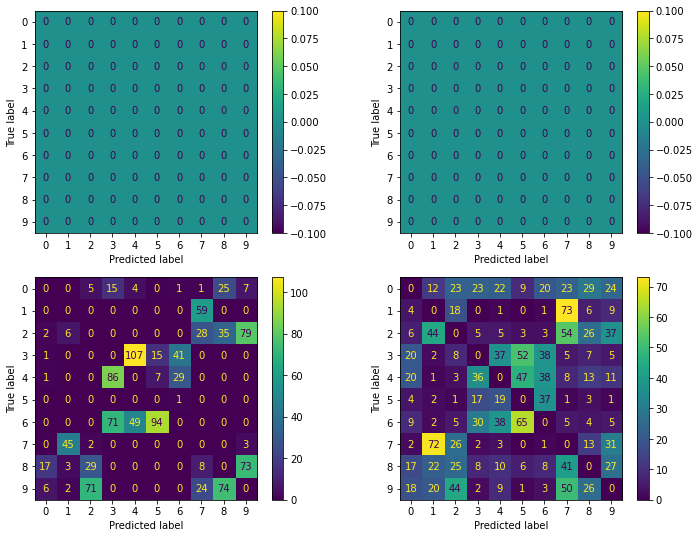

In [10]:
train, encoder, features = load_data()
train = flow_features(train)

oof_preds = score_model(GCDEstimator())
plot_confusion_matrix(train['target'],oof_preds, train_gcds)

# Data Augmentation

In [11]:
from collections import Counter

class Resampler(BaseEstimator):
    
    def __init__(self, num_samples):
        self.model = GCDEstimator()
        self.num_samples = num_samples
        
    def get_histograms(self, input_df):
        return pd.DataFrame({
            col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
        })
    
    def get_distributions(self, X, y):
        self.distributions = [None]*len(np.unique(y))
        for label in np.unique(y):
            self.distributions[label] = np.sum(X[y == label].values, axis = 0)
    
    def gcd_of_all(self, df_i):
        features = [x for x in df_i.columns]
        gcd = df_i[features[0]]
        for col in features[1:]:
            gcd = np.gcd(gcd, df_i[col])
        self.gcd = (gcd == 1)
        
    def fit(self, X, y, sample_weight):
        temp = self.get_histograms(X)
        self.get_distributions(temp, y)
        new_samples = self.get_samples(temp)
        temp = X.copy()
        temp['target'] = y
        temp = pd.concat([temp, new_samples], ignore_index = True)
        assert len(X) < len(temp)
        temp = temp.sample(frac=1).reset_index(drop=True)
        new_weights = np.append(sample_weight, [1,]*(len(new_samples)))
        self.model.fit(temp[X.columns], temp['target'], new_weights)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def get_samples(self, X):
        temp = dict()
        for k in [100, 1000]:
            for label, prob in enumerate(self.distributions):
                temp[label] = list()
                for _ in range(self.num_samples):
                    sample = Counter(choices(
                        X.columns,
                        weights = prob,
                        k = k
                    ))
                    for key in sample.keys():
                        sample[key] *= 1000000 // k
                    temp[label].append(sample)
        new_data = list()
        for label in temp.keys():
            temp_df = pd.DataFrame({
                col: [temp[label][i][col] for i in range(len(temp[label]))] for col in X.columns
            })
            temp_df = self.remove_bias(temp_df)
            temp_df['target'] = label
            new_data.append(temp_df)
        new_data = pd.concat(new_data, ignore_index = True)
        new_data = new_data.sample(frac=1).reset_index(drop=True)
        return new_data
        
    def remove_bias(self, input_df):
        new_data = input_df.copy()
        # Remove bias and normalize
        for col in features:
            new_data[col] -= bias_of(col)
            new_data[col] /= 1000000
        return new_data


Fold 0: 0.97935 accuracy in 153.63s.
Fold 1: 0.97573 accuracy in 156.42s.
Fold 2: 0.97637 accuracy in 154.58s.
Fold 3: 0.98016 accuracy in 153.34s.
Fold 4: 0.97734 accuracy in 153.94s.
Fold 5: 0.97822 accuracy in 154.93s.
Fold 6: 0.97621 accuracy in 154.41s.
Fold 7: 0.97669 accuracy in 156.02s.
Fold 8: 0.97839 accuracy in 155.87s.
Fold 9: 0.97871 accuracy in 158.84s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.92568
Accuracy (100 Reads): 0.89157
Average Accuracy: 0.97772
Training Time: 1551.97s


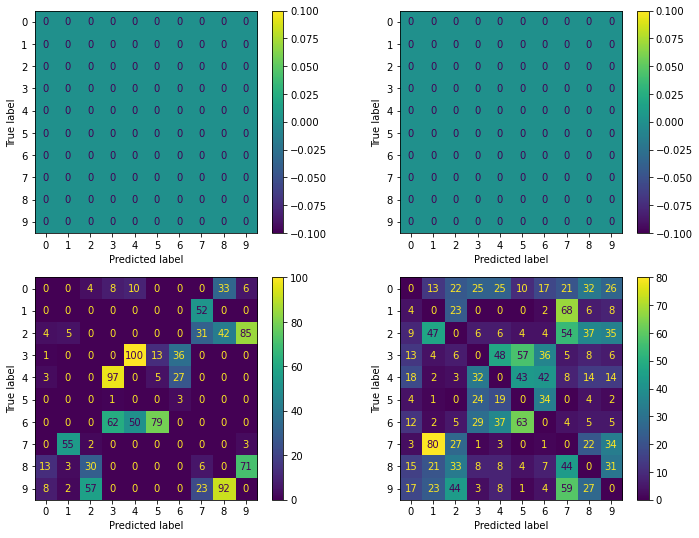

In [12]:
train, encoder, features = load_data()

oof_preds = score_model(Resampler(1500))
plot_confusion_matrix(train['target'], oof_preds, train_gcds)

# Low Resolution Validation

In [18]:
LOWRES_MASK = (train_gcds == 1000) | (train_gcds == 10000)
PARAM_VALUE = 'n_estimators'
PARAM_RANGE = np.arange(1550, 1701, 25)

In [19]:
train_scores, valid_scores = validation_curve(
    ExtraTreesClassifier(random_state = RANDOM_SEED, n_jobs = -1),
    train[LOWRES_MASK][features],
    train[LOWRES_MASK]['target'],
    cv = 5,
    param_name = PARAM_VALUE,
    param_range = PARAM_RANGE,
    fit_params = dict(
        sample_weight = train[LOWRES_MASK]['sample_weight']
    ),
    scoring = 'accuracy',
    verbose = 1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 33.3min finished


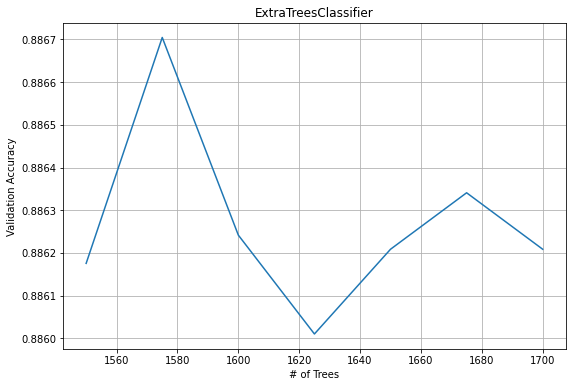

In [20]:
valid_scores = np.mean(valid_scores, axis = 1)

fig, ax = plt.subplots(figsize = (9,6))
ax.plot(PARAM_RANGE, valid_scores)
plt.ylabel('Validation Accuracy')
plt.xlabel('# of Trees')
plt.title('ExtraTreesClassifier')
plt.grid(True)
plt.show()